## Analysis the Result of Simulation

Analysis the result is performed for the affected lands and affected population by the flood. 

# Analysis of the FloodPlain Surface Area

In order to analyze the surface area of the floodplain, first we need to conver the raster files of flood to the vector file. For this purpose, we use **polygonize.py** function in Gdal library. Then using **Pandas** and **Geopandas** libraries the statistics of the vector files are retrieved. 

In [15]:
#importing the packages for analysis
import os
import glob
import pandas as pd
import geopandas as gpd
from rasterio.features import geometry_mask
import rasterio
import matplotlib.pyplot as plt
from rasterstats import zonal_stats
import warnings
warnings.filterwarnings('ignore')

## Polygonizing the flood maps

In [ ]:
#polygonize
#input and putput directory
flood_raster_path = '/home/sahar/SLR_Bonn_Polimi/output_tif/flood_maps_DE'
flood_vector_path = '/home/sahar/SLR_Bonn_Polimi/output_shp/flood_maps_DE'

#if not exist make the directory
os.makedirs(flood_vector_path, exist_ok=True)

# iterate over all the flood raster files
for raster_file in glob.glob(os.path.join(flood_raster_path, 'area_flood_*.tif')):
    
    #extract year
    year = raster_file.split('_')[-1].split('.')[0]
    
    #making the pattern for the output shapefile
    output_vector = os.path.join(flood_vector_path, f'floodNonflood_{year}.shp')
    
    #define gdalPolygonize as command
    gdal_polygonize_cmd = f"gdal_polygonize.py {raster_file} -f 'ESRI Shapefile' {output_vector}"

    #execute the command
    os.system(gdal_polygonize_cmd)
    
    #see the logs
    #print(f"Polygonization done for {raster_file}... {output_vector}")


# Computing the statistics of the flooded lands

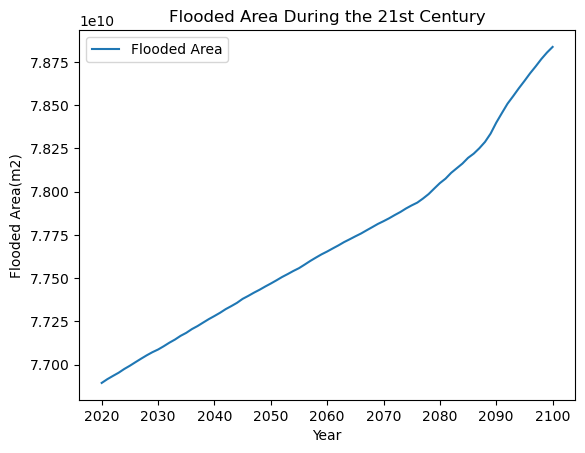

In [10]:
#area-computation
#in case I did not run the previous cell
#flood_vector_path = '/home/sahar/SLR_Bonn_Polimi/output_shp/flood_maps_DE'

#create an empty DataFrame to store the statistics
flood_df = pd.DataFrame(columns=['Year', 'Area'])

#iterate over flood vector
for shp_file in os.listdir(flood_vector_path):
    if shp_file.endswith('.shp') and shp_file.startswith('floodNonflood_'):
        #construct the full path to the shapefile
        shp_path = os.path.join(flood_vector_path, shp_file)

        #readin the shapefile with gpd
        gdf = gpd.read_file(shp_path)

        #reproject to UTM Zone 32N
        gdf_utm = gdf.to_crs(epsg=32632)

        #filter the GeoDataFrame for DN=1 which corresponds to the flooded in binary
        gdf_dn_1 = gdf_utm[gdf_utm['DN'] == 1]

        #compute the area
        area_m2 = gdf_dn_1.geometry.area.sum()

        #extract  the year
        year = int(shp_file.split('_')[-1].split('.')[0][-4:])

        #append the results to the DataFrame
        flood_df = flood_df.append({'Year': year, 'Area': area_m2}, ignore_index=True)

#sort the DataFrame by year
flood_df = flood_df.sort_values(by='Year')

#save the DataFrame to excel file
excel_output_file = '/home/sahar/SLR_Bonn_Polimi/Statistics/flood_area.xlsx'
flood_df.to_excel(excel_output_file, index=False)

#plot
plt.plot(flood_df['Year'], flood_df['Area'], label='Flooded Area')
plt.xlabel('Year')
plt.ylabel('Flooded Area(m2)')
plt.title('Flooded Area During the 21st Century')
plt.legend()
plt.show()


# Computing the Vulnerable Population
In order to compute the population in the flood risk in each year, Zonal Statistics from Rasterstats is used to calculate the number of people that are in flooded zones. Therefore, the flooded zones need to to be defined as a separated vector file. we select all feautures with DN=1 which corresponds to flooded zones with Geopandas library. In the next step, using the raster file of spatial destribution of population the zonal statistics is performed for both current (2020) and future population. In both cases global Mosaic with 30 arc-sec resultion is used.
link to the current population (2020) source: https://hub.worldpop.org/geodata/summary?id=24777
link to the projected population source: https://www.nature.com/articles/s41597-022-01675-x#Sec9


## Select new shapefile for DN=1

In [12]:
#create-shapefile-of-flood-DN=1-(only-flooded-area-for-the-zonal-statistics)
#in case I did not run the previous cell
#flood_vector_path = '/home/sahar/SLR_Bonn_Polimi/output_shp/flood_maps_DE

#iterate over all vectors
for filename in os.listdir(flood_vector_path):
    if filename.endswith(".shp"):
        #extract year
        year = filename.split('.')[0][-4:]

        #input shapefile path
        input_shapefile = os.path.join(flood_vector_path, filename)

        # Output shapefile path
        output_shapefile = os.path.join(flood_vector_path, f"flood1_{year}.shp")

        # Read the input shapefile
        gdf = gpd.read_file(input_shapefile)

        # Filter and save
        gdf[gdf['DN'] == 1].to_file(output_shapefile, driver='ESRI Shapefile')


## Zonal Stats for current PoP

In [ ]:
#worldPOP 2020- resolution 1km

#Input data path
worldpop2020 = "/home/sahar/SLR_Bonn_Polimi/Data/worldPOP/ppp_2020_1km_Aggregated.tif" #https://hub.worldpop.org/geodata/summary?id=24777
flood_vector_path = "/home/sahar/SLR_Bonn_Polimi/output_shp/flood_maps_DE"
output_statistics_path = "/home/sahar/SLR_Bonn_Polimi/Statistics"
excel_file_path = os.path.join(output_statistics_path, "flooded_pop_bbox.xlsx")

#find the flooded zones
floodNamePattern = "flood1_*.shp"
floods = glob.glob(os.path.join(flood_vector_path, floodNamePattern))

#initialize a list to store the pop2020List
pop2020List = []

#iterate through each shapefile and perform zonal statistics
for flood in floods:
    #extract the year 
    year = int(os.path.basename(flood).split('_')[1].split('.')[0])

    #perform zonal statistics for total popwithin each zone
    stats = zonal_stats(flood, worldpop2020, stats=["sum"])

    #calculate the overall total pop affected by the flood
    total_pop = sum(stat['sum'] if stat['sum'] is not None else 0 for stat in stats)

    #append to the list
    pop2020List.append({'Year': year, 'Affected Pop': total_pop})

#create a DataFrame from the pop2020List
df_pop2020 = pd.DataFrame(pop2020List)

#sort the DataFrame by year column
df_pop2020 = df_pop2020.sort_values(by='Year')

#a new column to have the affected pop wrt 2020
df_pop2020['Affected Pop_wrt_2020'] = df_pop2020['Affected Pop'] - df_pop2020.loc[df_pop2020['Year'] == 2020, 'Affected Population'].iloc[0]

#save  to the excelfile
df_pop2020[['Year', 'Affected Pop', 'Affected Pop_wrt_2020']].to_excel(excel_file_path, index=False)



## Zonal Stats for future PoP

In [4]:
#ProjPOP- resolution 1km
#input data paths
pop_prj = "/home/sahar/SLR_Bonn_Polimi/Data/POP/SPP2"
flood_vector_path = "/home/sahar/SLR_Bonn_Polimi/output_shp/flood_maps_DE"
output_statistics_path = "/home/sahar/SLR_Bonn_Polimi/Statistics"
excel_file_path = os.path.join(output_statistics_path, "flooded_pop_proj.xlsx")

#define the years of analysis (10-yr interval from 2020-2100)
yearss = list(range(2020, 2110, 10))

#initialize a list to store the pop_prj_list
pop_prj_list = []

#iterate through each year of interest
for year in yearss:
    #define patter
    flood_pattern = f"flood1_{year}.shp"
    
    #find the shapefile for the current year
    floodfile_paths = glob(os.path.join(flood_vector_path, flood_pattern))

    #check if the shapefile exists for the current year
    if floodfile_paths:
        #take the first matching shapefile path
        floodfile_path = floodfile_paths[0]

        #construct the raster file pattern for the current year
        popPrj_pattern = f"SSP2_{year}.tif"
        popPrj_path = os.path.join(pop_prj, popPrj_pattern)

        # Check if the raster file exists for the current year
        if os.path.exists(popPrj_path):
            # Perform zonal statistics for total pop within each zone
            stats = zonal_stats(floodfile_path, popPrj_path, stats=["sum"])

            #callculate the overall total pop affected by the flood
            overall_total_pop = sum(stat['sum'] if stat['sum'] is not None else 0 for stat in stats)

            # Append the pop_prj_list to the list
            pop_prj_list.append({'Year': year, 'Affected pop': overall_total_pop})

#create a DataFrame from the pop_prj_list
df = pd.DataFrame(pop_prj_list)

#save the DataFrame to the excel
df.to_excel(excel_file_path, index=False)
